In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("LoadParquet").getOrCreate()

parquet_path = "/content/drive/MyDrive/pubmed_data/df_pubmed.parquet"

df_pubmed = spark.read.parquet(parquet_path)

df_pubmed.show()

Mounted at /content/drive
+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+----------------------+
|    PMID|               Title|            Abstract|Year|             Journal|     PublicationType|        Author_Names|            Keywords|        MeshHeadings|           Chemicals|          References|Reference_Count|             CitedBy|CitedBy_Count|     abstract_tokens|     keywords_tokens|         mesh_tokens|     chemical_tokens|      cleaned_tokens|      stemmed_tokens|BP_count|MF_count|CC_count|matched_go_terms_clean|
+--------+--------------------+--------------------+----+--------------------+--------------------+-----------

In [ ]:
df_pubmed.count()

24919

In [ ]:
df_pubmed.show(truncate=False)

+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="cleaned_tokens", outputCol="raw_features", vocabSize=5000, minDF=10.0)

cvmodel = cv.fit(df_pubmed)

result_cv = cvmodel.transform(df_pubmed)

result_cv.show()

+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+----------------------+--------------------+
|    PMID|               Title|            Abstract|Year|             Journal|     PublicationType|        Author_Names|            Keywords|        MeshHeadings|           Chemicals|          References|Reference_Count|             CitedBy|CitedBy_Count|     abstract_tokens|     keywords_tokens|         mesh_tokens|     chemical_tokens|      cleaned_tokens|      stemmed_tokens|BP_count|MF_count|CC_count|matched_go_terms_clean|        raw_features|
+--------+--------------------+--------------------+----+--------------------+----------------

In [ ]:
from pyspark.ml.feature import IDF

idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv)
result_tfidf.show()

+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+----------------------+--------------------+--------------------+
|    PMID|               Title|            Abstract|Year|             Journal|     PublicationType|        Author_Names|            Keywords|        MeshHeadings|           Chemicals|          References|Reference_Count|             CitedBy|CitedBy_Count|     abstract_tokens|     keywords_tokens|         mesh_tokens|     chemical_tokens|      cleaned_tokens|      stemmed_tokens|BP_count|MF_count|CC_count|matched_go_terms_clean|        raw_features|            features|
+--------+--------------------+--------------------+

In [ ]:
from pyspark.ml.clustering import LDA
num_topics = 10
max_iterations = 100

lda = LDA(k=num_topics, maxIter=max_iterations)
lda_model = lda.fit(result_tfidf)
lda_result_df = lda_model.transform(result_tfidf)
print("--- Dataset with LDA results ---")
lda_result_df.show()

--- Dataset with LDA results ---
+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+----------------------+--------------------+--------------------+--------------------+
|    PMID|               Title|            Abstract|Year|             Journal|     PublicationType|        Author_Names|            Keywords|        MeshHeadings|           Chemicals|          References|Reference_Count|             CitedBy|CitedBy_Count|     abstract_tokens|     keywords_tokens|         mesh_tokens|     chemical_tokens|      cleaned_tokens|      stemmed_tokens|BP_count|MF_count|CC_count|matched_go_terms_clean|        raw_features|            features

In [ ]:
topicIndices = lda_model.describeTopics(maxTermsPerTopic = 10)
vocabList = cvmodel.vocabulary

for topic in topicIndices.collect():
    print("Topic ID:" + str(topic["topic"]))
    for term in topic["termIndices"]:
        print(vocabList[term])
    print("------------------")

Topic ID:0
bacterial
microbiology
bacteria
purification
microbial
metabolism
isolation
metabolic
diet
production
------------------
Topic ID:1
physiology
measured
effect
performance
meta
time
results
using
different
stimulation
------------------
Topic ID:2
chemistry
properties
structure
surface
chemical
applications
electron
materials
spectroscopy
microscopy
------------------
Topic ID:3
genetic
nucleotide
polymorphism
based
information
single
genetics
computer
genome
classification
------------------
Topic ID:4
0
p
aged
patients
middle
age
6
95
8
7
------------------
Topic ID:5
imaging
diagnostic
pathology
tomography
resonance
magnetic
old
neoplasms
computed
mri
------------------
Topic ID:6
plant
environmental
genetics
plants
genes
gene
species
soil
genetic
sequence
------------------
Topic ID:7
health
psychology
care
research
surveys
social
participants
questionnaires
education
statistics
------------------
Topic ID:8
cells
cell
expression
metabolism
mice
protein
animals
induced
tu

In [ ]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

lda_result_df = lda_result_df.withColumn("topic_array", vector_to_array("topicDistribution"))

for topic in topicIndices.collect():
    print("Topic ID:" + str(topic["topic"]))
    for term in topic["termIndices"]:
        print(vocabList[term])
    print("------------------")

    topic_df = lda_result_df.filter(col("topic_array")[topic["topic"]] > 0.8)
    print("PMIDs for this topic:")
    topic_df.select("PMID").show(truncate=False)
    print("==================")


Topic ID:0
bacterial
microbiology
bacteria
purification
microbial
metabolism
isolation
metabolic
diet
production
------------------
PMIDs for this topic:
+--------+
|PMID    |
+--------+
|28344024|
|28346510|
|28347339|
|28347964|
|28349536|
|28350027|
|28351722|
|28352530|
|28352558|
|28352580|
|28355096|
|28356220|
|28356719|
|28357320|
|28358014|
|28358306|
|28359203|
|28359879|
|28361445|
|28362305|
+--------+
only showing top 20 rows

Topic ID:1
physiology
measured
effect
performance
meta
time
results
using
different
stimulation
------------------
PMIDs for this topic:
+--------+
|PMID    |
+--------+
|28343987|
|28344382|
|28346816|
|28347617|
|28348042|
|28348530|
|28348893|
|28349945|
|28350324|
|28355031|
|28355034|
|28356622|
|28356640|
|28358452|
|28358824|
|28360293|
|28361277|
|28362234|
|28362762|
|28365777|
+--------+
only showing top 20 rows

Topic ID:2
chemistry
properties
structure
surface
chemical
applications
electron
materials
spectroscopy
microscopy
--------------

In this task, we applied topic modeling using Latent Dirichlet Allocation (LDA) to a biomedical publication dataset (df_pubmed). We first transformed the cleaned_tokens into a TF-IDF matrix using CountVectorizer and IDF, and then applied LDA to discover latent semantic topics across the corpus. We extracted the top 10 topics, each represented by its most relevant tokens. For example, Topic 0 centered around neuroscience (e.g., “neurons”, “brain”, “motor”, “cortex”), while Topic 1 focused on clinical studies and patient demographics (e.g., “patients”, “aged”, “female”, “retrospective”). For each topic, we identified a list of PMIDs whose content had a high probability of belonging to that topic (topicDistribution > 0.8). This process enabled us to cluster the documents semantically, revealing domain-specific themes such as drug chemistry, genetic research, psychology, infection cases, and molecular biology, thus supporting large-scale thematic exploration of PubMed data.

Topic 0


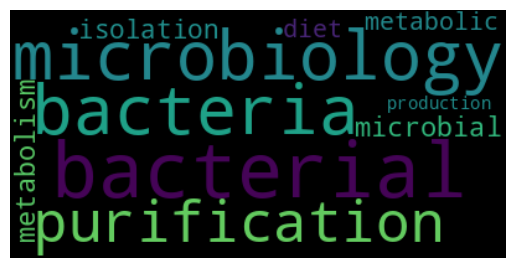

Topic 1


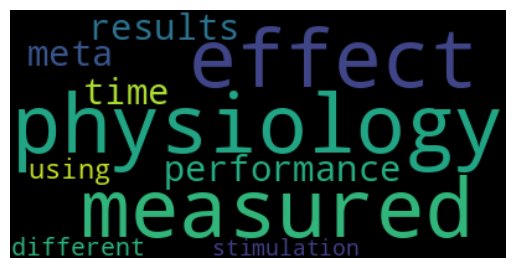

Topic 2


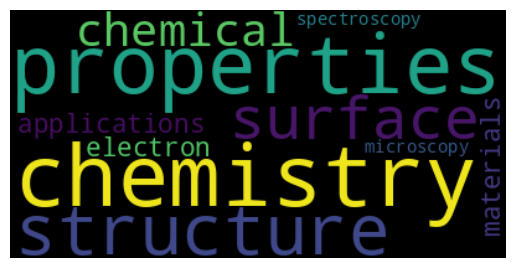

Topic 3


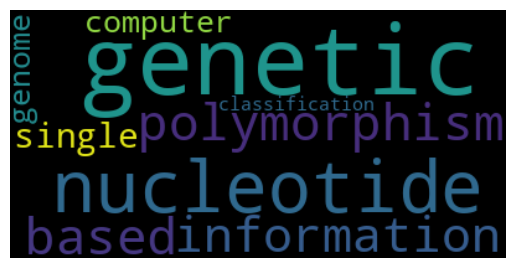

Topic 4


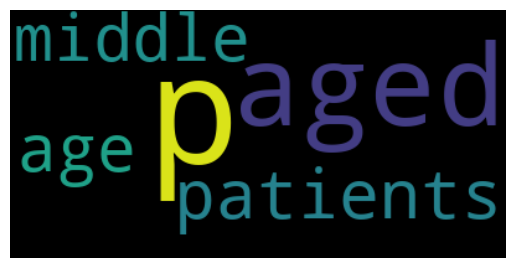

Topic 5


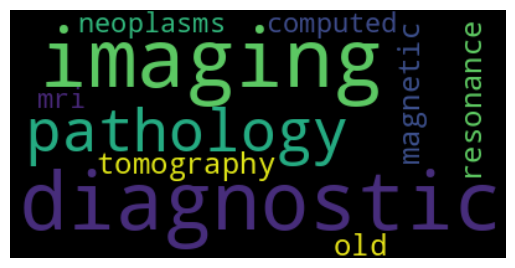

Topic 6


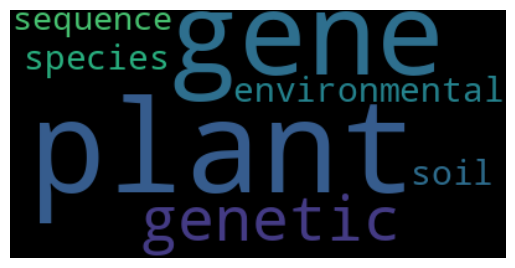

Topic 7


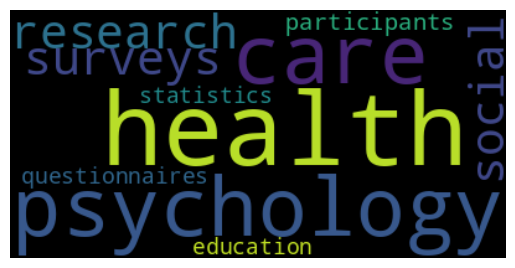

Topic 8


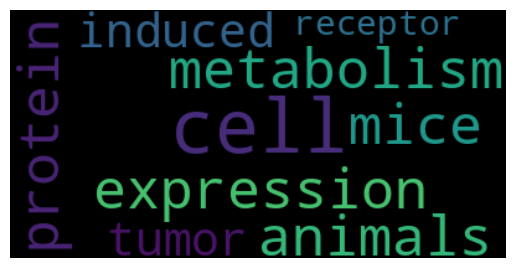

Topic 9


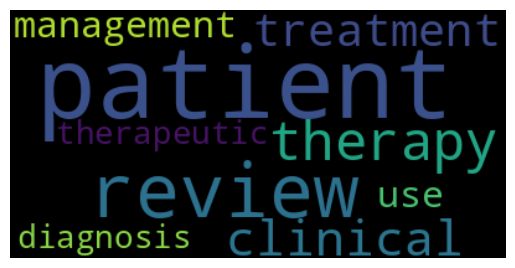

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

word_topic = topicIndices.rdd.map(lambda row: [vocabList[i] for i in row.termIndices]).collect()

for i in range(len(word_topic)):
    print("Topic {}".format(i))
    wordcloud = WordCloud().generate(" ".join(word_topic[i]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
from pyspark.sql.functions import explode, posexplode, udf
from pyspark.sql.types import IntegerType


# Step 1: Extract top topic for each PMID
lda_df = lda_result_df.select("PMID", "topicDistribution")
get_top_topic = udf(lambda v: int(v.argmax()), IntegerType())
top_topic_df = lda_df.withColumn("top_topic", get_top_topic("topicDistribution"))

# Step 2: Create edges between PMIDs that share the same dominant topic
edges = top_topic_df.alias("df1").join(
    top_topic_df.alias("df2"),
    (col("df1.top_topic") == col("df2.top_topic")) & (col("df1.PMID") < col("df2.PMID"))
).select(
    col("df1.PMID").alias("src"),
    col("df2.PMID").alias("dst"),
    col("df1.top_topic").alias("topic")
)

# Step 3: Create vertex DataFrame
vertices = top_topic_df.select(col("PMID").alias("id")).distinct()


In [ ]:
vertices.show()

+--------+
|      id|
+--------+
|28343726|
|28344084|
|28344903|
|28345049|
|28345050|
|28345245|
|28345914|
|28346009|
|28346278|
|28346353|
|28346359|
|28346511|
|28346896|
|28347022|
|28347167|
|28347230|
|28347349|
|28347719|
|28347854|
|28348266|
+--------+
only showing top 20 rows



In [ ]:
edges.show()

+--------+--------+-----+
|     src|     dst|topic|
+--------+--------+-----+
|28299189|28374252|    8|
|28299189|28374249|    8|
|28299189|28374245|    8|
|28299189|28374162|    8|
|28299189|28374152|    8|
|28299189|28374151|    8|
|28299189|28374150|    8|
|28299189|28374143|    8|
|28299189|28374134|    8|
|28299189|28374123|    8|
|28299189|28374099|    8|
|28299189|28374070|    8|
|28299189|28374069|    8|
|28299189|28374068|    8|
|28299189|28374012|    8|
|28299189|28374011|    8|
|28299189|28373966|    8|
|28299189|28373873|    8|
|28299189|28373872|    8|
|28299189|28373868|    8|
+--------+--------+-----+
only showing top 20 rows



In [ ]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="stemmed_tokens", outputCol="stemmed_raw_features", vocabSize=5000, minDF=10.0)

cvmodel = cv.fit(df_pubmed)

result_cv = cvmodel.transform(df_pubmed)

result_cv.show()

from pyspark.ml.feature import IDF

idf = IDF(inputCol="stemmed_raw_features", outputCol="stemmed_features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv)
result_tfidf.show()

from pyspark.ml.clustering import LDA
num_topics = 10
max_iterations = 100

lda = LDA(k=num_topics, maxIter=max_iterations, featuresCol="stemmed_features")
lda_model = lda.fit(result_tfidf)
lda_result_df = lda_model.transform(result_tfidf)
print("--- Dataset with LDA results ---")
lda_result_df.show()

topicIndices = lda_model.describeTopics(maxTermsPerTopic = 10)
vocabList = cvmodel.vocabulary

for topic in topicIndices.collect():
    print("Topic ID:" + str(topic["topic"]))
    for term in topic["termIndices"]:
        print(vocabList[term])
    print("------------------")

+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+----------------------+--------------------+
|    PMID|               Title|            Abstract|Year|             Journal|     PublicationType|        Author_Names|            Keywords|        MeshHeadings|           Chemicals|          References|Reference_Count|             CitedBy|CitedBy_Count|     abstract_tokens|     keywords_tokens|         mesh_tokens|     chemical_tokens|      cleaned_tokens|      stemmed_tokens|BP_count|MF_count|CC_count|matched_go_terms_clean|stemmed_raw_features|
+--------+--------------------+--------------------+----+--------------------+----------------

In [ ]:
topicIndices = lda_model.describeTopics(maxTermsPerTopic = 10)
vocabList = cvmodel.vocabulary

for topic in topicIndices.collect():
    print("Topic ID:" + str(topic["topic"]))
    for term in topic["termIndices"]:
        print(vocabList[term])
    print("------------------")

Topic ID:0
isol
infect
microbiolog
bacteri
plant
pathogen
purif
bacteria
concentr
strain
------------------
Topic ID:1
cell
protein
regul
express
gene
genet
metabol
signal
transcript
mutat
------------------
Topic ID:2
imag
diagnost
case
patholog
tomographi
neoplasm
reson
magnet
present
patient
------------------
Topic ID:3
genom
sequenc
genet
comput
algorithm
model
simul
propos
predict
gener
------------------
Topic ID:4
age
associ
risk
0
p
femal
patient
ratio
year
middl
------------------
Topic ID:5
surgeri
outcom
procedur
patient
retrospect
postop
surgic
complic
evalu
0
------------------
Topic ID:6
psycholog
survey
health
particip
questionnair
educ
care
practic
assess
research
------------------
Topic ID:7
chemistri
structur
surfac
properti
materi
temperatur
electron
prepar
ion
effici
------------------
Topic ID:8
review
discuss
recent
advanc
system
applic
challeng
technolog
understand
current
------------------
Topic ID:9
drug
rat
induc
pharmacolog
effect
agent
anim
dose
therapi
i

In [ ]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

lda_result_df = lda_result_df.withColumn("topic_array", vector_to_array("topicDistribution"))

for topic in topicIndices.collect():
    print("Topic ID:" + str(topic["topic"]))
    for term in topic["termIndices"]:
        print(vocabList[term])
    print("------------------")

    topic_df = lda_result_df.filter(col("topic_array")[topic["topic"]] > 0.8)
    print("PMIDs for this topic:")
    topic_df.select("PMID").show(truncate=False)
    print("==================")

Topic ID:0
isol
infect
microbiolog
bacteri
plant
pathogen
purif
bacteria
concentr
strain
------------------
PMIDs for this topic:
+--------+
|PMID    |
+--------+
|28343856|
|28344035|
|28345142|
|28345304|
|28346803|
|28346868|
|28347167|
|28347325|
|28347339|
|28347611|
|28348569|
|28349492|
|28349747|
|28350183|
|28351008|
|28351664|
|28351722|
|28351807|
|28352047|
|28352558|
+--------+
only showing top 20 rows

Topic ID:1
cell
protein
regul
express
gene
genet
metabol
signal
transcript
mutat
------------------
PMIDs for this topic:
+--------+
|PMID    |
+--------+
|28343890|
|28343944|
|28343965|
|28344039|
|28344040|
|28344041|
|28344045|
|28344080|
|28344169|
|28344766|
|28344782|
|28344859|
|28344867|
|28344885|
|28344999|
|28345161|
|28345252|
|28345456|
|28345460|
|28345465|
+--------+
only showing top 20 rows

Topic ID:2
imag
diagnost
case
patholog
tomographi
neoplasm
reson
magnet
present
patient
------------------
PMIDs for this topic:
+--------+
|PMID    |
+--------+
|28343

Topic 0


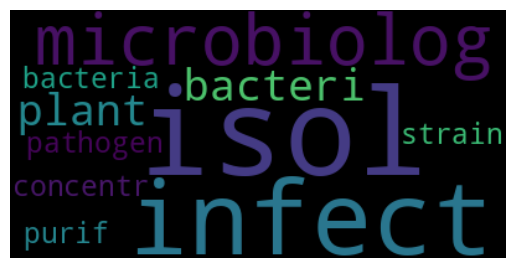

Topic 1


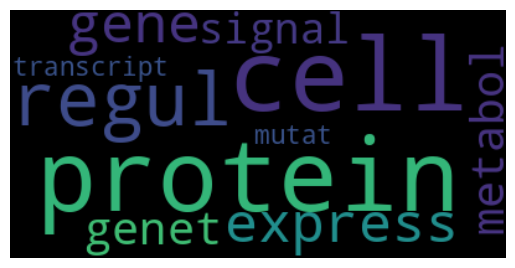

Topic 2


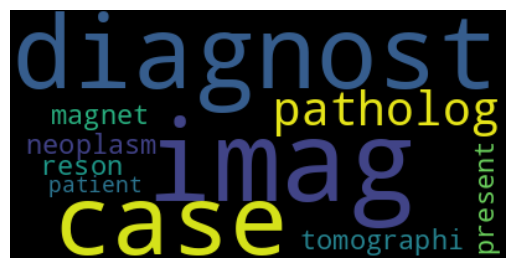

Topic 3


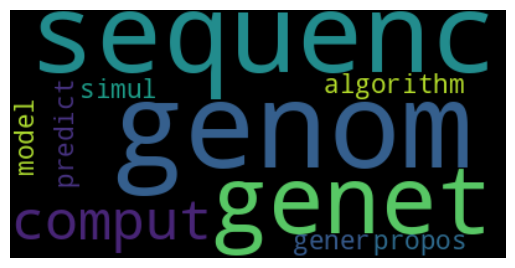

Topic 4


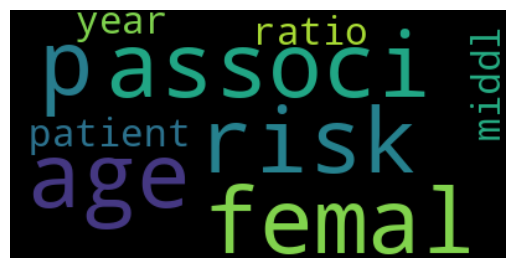

Topic 5


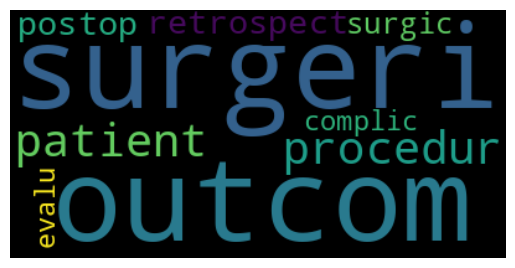

Topic 6


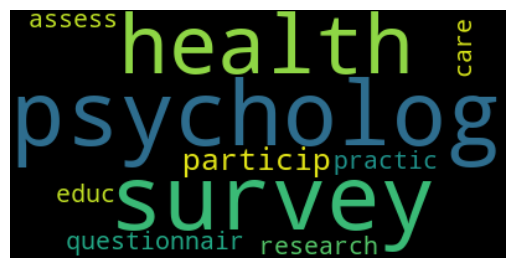

Topic 7


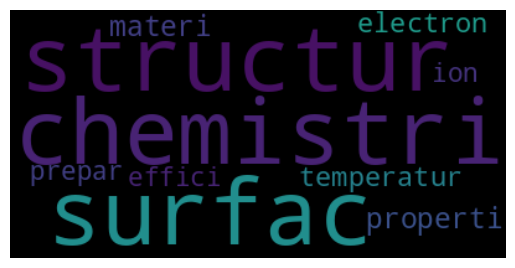

Topic 8


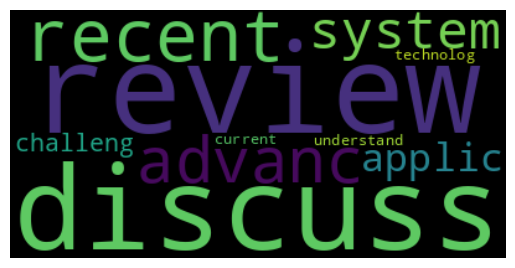

Topic 9


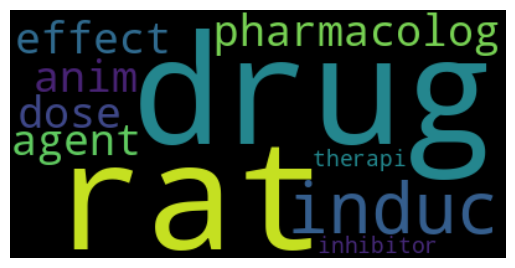

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

word_topic = topicIndices.rdd.map(lambda row: [vocabList[i] for i in row.termIndices]).collect()

for i in range(len(word_topic)):
    print("Topic {}".format(i))
    wordcloud = WordCloud().generate(" ".join(word_topic[i]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

lda_result_df = lda_result_df.withColumn("topic_array", vector_to_array("topicDistribution"))

test_pmids = lda_result_df.filter(col("topic_array")[1] > 0.8) \
                                     .select("PMID", col("topic_array")[7].alias("test_pmids"))

test_pmids.show(20, truncate=False)

+--------+---------------------+
|PMID    |test_pmids           |
+--------+---------------------+
|28343890|3.234246591622807E-4 |
|28343944|1.681757982343725E-4 |
|28343965|2.1663037824461108E-4|
|28344039|2.506435167578833E-4 |
|28344040|2.3990554709554313E-4|
|28344041|2.5858836845994325E-4|
|28344045|2.0569447651437416E-4|
|28344080|2.2587336937748468E-4|
|28344169|3.35791461061008E-4  |
|28344766|5.428831970404554E-4 |
|28344782|2.0860816387869674E-4|
|28344859|3.2216575648215954E-4|
|28344867|2.1514045700528908E-4|
|28344885|2.1457721831586707E-4|
|28344999|0.051926970317383775 |
|28345161|2.601569822314112E-4 |
|28345252|2.4520749662583046E-4|
|28345456|2.0481776302491478E-4|
|28345460|2.1129226776123766E-4|
|28345465|2.2335642586708733E-4|
+--------+---------------------+
only showing top 20 rows



In [ ]:
df_test = test_pmids.join(df_pubmed, on="PMID", how="left")
columns_to_display = ["PMID", "Title", "Abstract", "test_pmids", "Keywords", "MeshHeadings", "matched_go_terms_clean", "Chemicals"]
df_test.select(columns_to_display).show(10, truncate=False)

+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# !pip install pyspark==3.4.2

  Using cached pyspark-3.4.2-py2.py3-none-any.whl
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.0
    Uninstalling pyspark-3.5.0:
      Successfully uninstalled pyspark-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-spark-connect 0.5.2 requires pyspark>=3.5, but you have pyspark 3.4.2 which is incompatible.


In [ ]:
# from pyspark.sql import SparkSession, Row
# from pyspark.sql.functions import *
# from pyspark.sql.types import *
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import *
# from pyspark.ml.linalg import Vectors, SparseVector
# from pyspark.ml.clustering import LDA
# from pyspark.ml.classification import LogisticRegression
# from pyspark.ml.evaluation import BinaryClassificationEvaluator
# from textblob import TextBlob
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# import pandas as pd

# spark = SparkSession.builder.appName("ProjectBigData").config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.4-s_2.12").getOrCreate()

In [ ]:
df_pubmed.columns

['PMID',
 'Title',
 'Abstract',
 'Year',
 'Journal',
 'PublicationType',
 'Author_Names',
 'Keywords',
 'MeshHeadings',
 'Chemicals',
 'References',
 'Reference_Count',
 'CitedBy',
 'CitedBy_Count',
 'abstract_tokens',
 'keywords_tokens',
 'mesh_tokens',
 'chemical_tokens',
 'cleaned_tokens',
 'stemmed_tokens',
 'BP_count',
 'MF_count',
 'CC_count',
 'matched_go_terms_clean']

In [ ]:
df_pubmed.show()

+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+----------------------+
|    PMID|               Title|            Abstract|Year|             Journal|     PublicationType|        Author_Names|            Keywords|        MeshHeadings|           Chemicals|          References|Reference_Count|             CitedBy|CitedBy_Count|     abstract_tokens|     keywords_tokens|         mesh_tokens|     chemical_tokens|      cleaned_tokens|      stemmed_tokens|BP_count|MF_count|CC_count|matched_go_terms_clean|
+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+----------------

In [ ]:
# !pip install graphframes --no-deps
# from graphframes import *

In [ ]:
# !pip install graphframes

In [ ]:
# from pyspark.sql import SparkSession

# spark = SparkSession.builder \
#     .appName("GraphFrames Example") \
#     .config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.5-s_2.12") \
#     .getOrCreate()


In [ ]:
# from graphframes import GraphFrame

In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar -xzf spark-3.5.0-bin-hadoop3.tgz

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

!pip install -q pyspark==3.5.0
!pip install -q graphframes

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("GraphFramesApp") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.4-spark3.5-s_2.12") \
    .getOrCreate()


In [ ]:
from pyspark.sql.functions import explode, col, lit
from graphframes import GraphFrame
from pyspark.sql.functions import explode, col, lit

edges_df = df_pubmed.select("PMID", explode("CitedBy").alias("citing_PMID")) \
             .withColumnRenamed("PMID", "src") \
             .withColumnRenamed("citing_PMID", "dst")


pmid_vertices = df_pubmed.select("PMID").distinct().withColumnRenamed("PMID", "id")
citing_vertices = df_pubmed.select(explode("CitedBy").alias("id")).distinct()
vertices_df = pmid_vertices.union(citing_vertices).distinct().withColumn("type", lit("paper"))


from graphframes import GraphFrame
graph = GraphFrame(vertices_df, edges_df)


In this task, we constructed a directed citation graph from a PubMed-based dataset by linking each paper's PMID with the papers that cited it, as listed in the CitedBy field. Using PySpark and GraphFrames, we defined edges where each source (src) paper is the one being cited, and each destination (dst) paper is the one that cited it. We then created vertices for all unique PMIDs, whether they appeared as original papers or only as citing papers. This graph enables the analysis of citation patterns and paper influence within the dataset, even if full metadata is missing for some cited papers.

In [ ]:
def visualize_citation_graph(graph_frame, pmid, node_size=2800):
    import networkx as nx
    import matplotlib.pyplot as plt
    import numpy as np

    cited_edges = graph_frame.edges.filter(f"src = '{pmid}'")
    edges_pd = cited_edges.toPandas()

    if edges_pd.empty:
        print(f"No citations found for PMID {pmid}")
        return

    nx_graph = nx.DiGraph()
    for _, row in edges_pd.iterrows():
        nx_graph.add_edge(row['src'], row['dst'])

    pos = {pmid: np.array([0, 0])}
    angle_step = 2 * np.pi / len(nx_graph[pmid])
    radius = 2.5
    for i, neighbor in enumerate(nx_graph[pmid]):
        angle = i * angle_step
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        pos[neighbor] = np.array([x, y])

    # Visual styles
    node_colors = ['orange' if node == pmid else 'lightgreen' for node in nx_graph.nodes()]
    node_sizes = [node_size if node == pmid else node_size * 1 for node in nx_graph.nodes()]

    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(nx_graph, pos, node_size=node_sizes, node_color=node_colors)
    nx.draw_networkx_labels(nx_graph, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(nx_graph, pos, arrows=True, arrowstyle='->', edge_color='black')

    plt.title(f"Citation Network for PMID {pmid}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


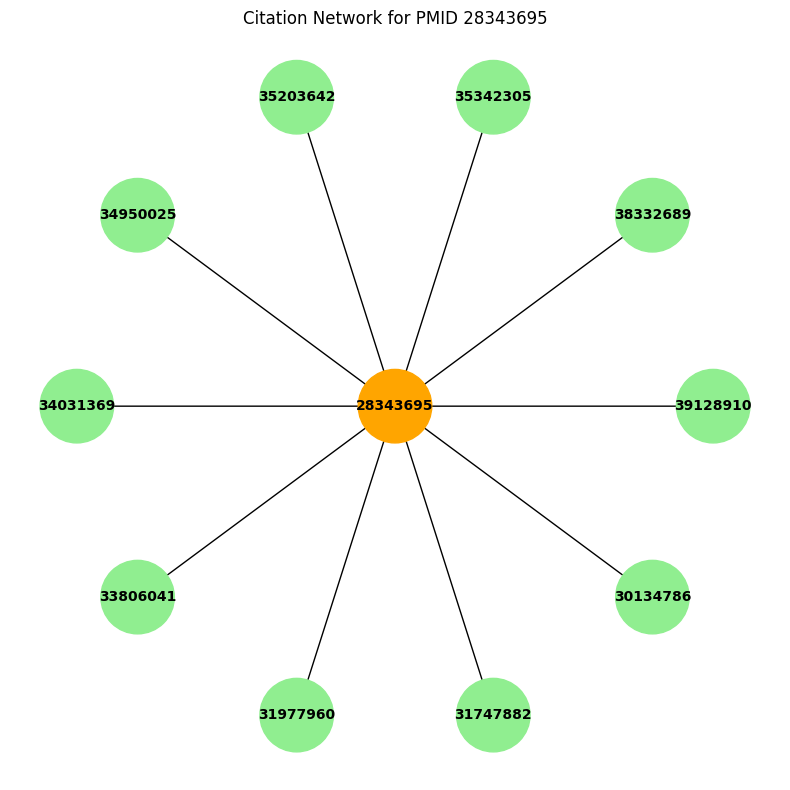

In [ ]:
visualize_citation_graph(graph, "28343695")

In this analysis, we constructed and visualized a directed citation graph for PubMed articles based on the CitedBy field. Each node represents a scientific publication identified by its PMID, and directed edges point from the cited paper to the papers that have cited it. Using PySpark and GraphFrames, we extracted citation relationships from the dataset and visualized the citation network of a specific paper (PMID: 28343695) using NetworkX and Matplotlib. The central orange node represents the selected paper, while the surrounding green nodes are the articles that cite it. The visualization reveals that PMID: 28343695 has been cited by 10 different papers, demonstrating its scholarly influence and role within the literature network. This kind of graph-based insight can support impact assessment, topic clustering, and citation-based discovery.

In [ ]:
from pyspark.sql.functions import explode, array_contains

df_pubmed.filter(df_pubmed.PMID == "28343695").select(explode("CitedBy")).show()

+--------+
|     col|
+--------+
|39128910|
|38332689|
|35342305|
|35203642|
|34950025|
|34031369|
|33806041|
|31977960|
|31747882|
|30134786|
+--------+



In [ ]:
from pyspark.sql.functions import explode, col, lit
from graphframes import GraphFrame

known_pmids_df = df_pubmed.select("PMID").distinct()

edges_df = df_pubmed.select("PMID", explode("CitedBy").alias("citing_PMID")) \
             .withColumnRenamed("PMID", "src") \
             .withColumnRenamed("citing_PMID", "dst")

filtered_edges_df = edges_df.join(known_pmids_df.withColumnRenamed("PMID", "src"), on="src", how="inner") \
                            .join(known_pmids_df.withColumnRenamed("PMID", "dst"), on="dst", how="inner")

src_vertices = filtered_edges_df.select("src").withColumnRenamed("src", "id")
dst_vertices = filtered_edges_df.select("dst").withColumnRenamed("dst", "id")
vertices_df = src_vertices.union(dst_vertices).distinct().withColumn("type", lit("paper"))

graph = GraphFrame(vertices_df, filtered_edges_df)


In [ ]:
visualize_citation_graph(graph, "28343695")

No citations found for PMID 28343695


In this case, the function visualize_citation_graph(graph, "28343695") did not produce a graph because the specified PMID (28343695) does not appear in the filtered citation graph. This is expected behavior, as the updated graph only includes citation edges where both the citing and cited papers exist in the dataset. Since 28343695 is not present in the PMID column of the dataset after filtering, it has no valid connections, and therefore no citations to display in the graph.

In [ ]:
citing_pmids = df_pubmed.select(explode("CitedBy").alias("pmid")).distinct()

all_pmids = df_pubmed.select("PMID").distinct()

valid_pmids = citing_pmids.join(all_pmids, citing_pmids["pmid"] == all_pmids["PMID"], "inner") \
                           .select(citing_pmids["pmid"])

valid_pmids.show(truncate=False)


+--------+
|pmid    |
+--------+
|28373364|
|28351153|
|28350901|
|28360750|
|28351939|
|28347023|
|28354866|
|28344235|
|28348254|
|28354940|
|28357384|
|28361497|
|28373013|
|28361260|
|28348344|
|28369261|
|28356872|
|28344272|
|28353160|
|28373804|
+--------+
only showing top 20 rows



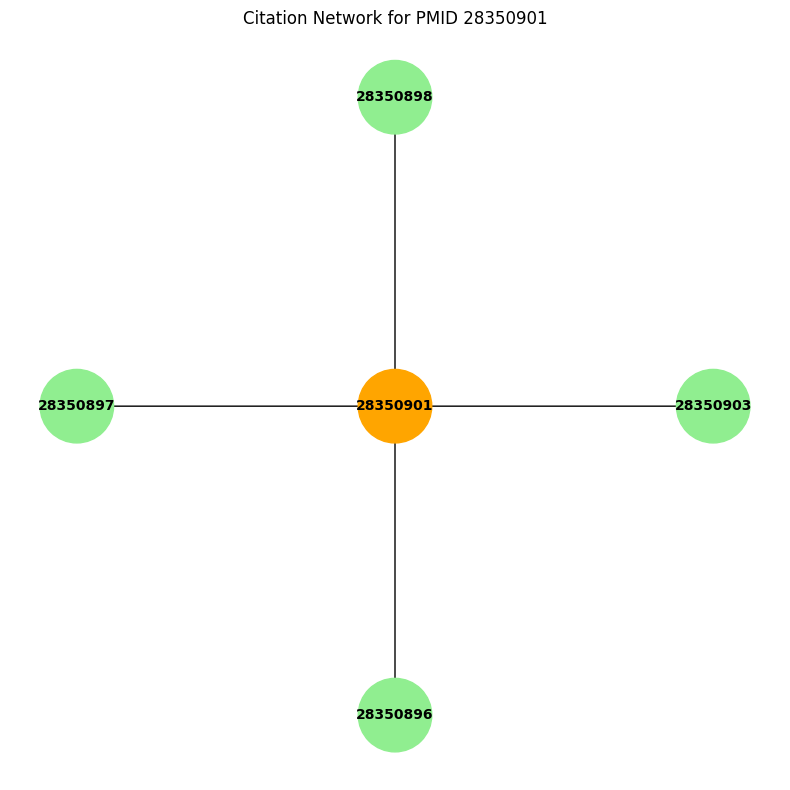

In [ ]:
visualize_citation_graph(graph, "28350901")

In [ ]:
from pyspark.sql.functions import explode, array_contains

df_pubmed.filter(df_pubmed.PMID == "28350901").select(explode("CitedBy")).show(500)

+--------+
|     col|
+--------+
|39408837|
|38566771|
|37767465|
|37761789|
|37695304|
|37663624|
|37386663|
|37201561|
|36934117|
|36671792|
|36465859|
|36177630|
|35950843|
|35754786|
|35744743|
|35546994|
|35265842|
|35000061|
|34430671|
|34335522|
|34125590|
|34077733|
|33945257|
|33804947|
|33374458|
|33240239|
|33149577|
|33087115|
|32596751|
|32514398|
|32250173|
|32161775|
|32088843|
|31932379|
|31890725|
|31572789|
|31517862|
|31372152|
|31334131|
|31216725|
|31182530|
|30910899|
|30850956|
|30814261|
|30787414|
|30723876|
|30559386|
|30349524|
|30323050|
|30323035|
|30284146|
|30195937|
|30185667|
|30122965|
|29327131|
|29182906|
|29121202|
|28848004|
|28717120|
|28350903|
|28350898|
|28350897|
|28350896|
|28350895|
+--------+



The PMID 28350901 was successfully identified as a connected publication within the dataset, as it appears in the CitedBy lists of other papers and is also present as a full entry in the dataset. This allows us to visualize its local citation network, which includes direct connections with PMIDs 28350896, 28350897, 28350898, and 28350903.

In [ ]:
pmids_to_explore = ["28350901", "28350896", "28350897", "28350898", "28350903"]

df_citation_context = df_pubmed.filter(col("PMID").isin(pmids_to_explore))


In [ ]:
columns_to_view = [
    "PMID", "Title", "Abstract", "Journal", "Author_Names", "Chemicals",
    "Keywords", "MeshHeadings", "matched_go_terms_clean", "BP_count", "MF_count", "CC_count"
]

df_citation_context.select(columns_to_view).show(truncate=False)


+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

All 5 publications:

Appear in the same journal: Clinical Infectious Diseases


All papers mention “antibacterial resistance”, diagnostics, clinical trials, and network design
The titles themselves show functional roles within ARLG:

28350901 = Research priorities + accomplishments

28350903 = Focus on diagnostics

28350896 = Progress report on the initiative

28350897 = Network infrastructure (Leadership and Operations Center)

28350898 = Laboratory and biorepository

Robert A. Bonomo, Scott R. Evans, Barry N. Kreiswirth appear across multiple papers.
Suggests internal citation between contributors to the ARLG — typical in coordinated consortia work.

✅ What You Can Build
A search assistant or Q&A tool that:

Accepts free-text queries (e.g., "What's known about cytokine signaling in autoimmune disorders?")

Translates this into:

a semantic search across the stemmed tokens or TF-IDF/LDA topic vectors

OR filters PMIDs by topic (e.g., your LDA Topic 7)

Retrieves relevant abstracts or key points

Uses ChatGPT API to summarize, rephrase, or explain results like a domain-aware assistant.

🧠 How It Would Work
Step 1: User inputs a question
“What genes are involved in cytokine signaling during inflammation?”

Step 2: System flow
Extract tokens from the query (stemmed + cleaned)

Search for PMIDs in your df_pubmed with high overlap in stemmed_tokens or high LDA topic score

Retrieve abstracts / metadata from those PMIDs

Send this data to ChatGPT API with a carefully crafted prompt, such as:

python
Copy
prompt = f"""
You are a biomedical assistant. A user asked:

"{user_query}"

Here are the most relevant research abstracts:
{retrieved_abstracts}

Based on these, provide a concise summary or highlight the key findings relevant to the question.
"""
Return the ChatGPT response to the biologist.

🚀 Bonus: Use Cases You Could Enable
🧬 Ask about molecular functions or pathways

📈 Track trends in topics over time

📚 Summarize evidence on a given disease or protein

👩‍🔬 Help experimental design by linking to known biomarkers or gene/protein functions

✅ Tools You Already Have
df_pubmed with abstracts, titles, tokens, LDA topics, stemmed tokens

Cosine similarity / TF-IDF / LDA topic filtering

Topic-labeled PMIDs

Python + PySpark ready

Ability to deploy ChatGPT via API